In [1]:
import numpy as np
import h5py
import jax
import jax.numpy as jnp

from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt

In [4]:
with h5py.File('../visualization/pc_examples_fastdecay.h5', 'r') as f:
    pc_traces = np.array(f['traces'])

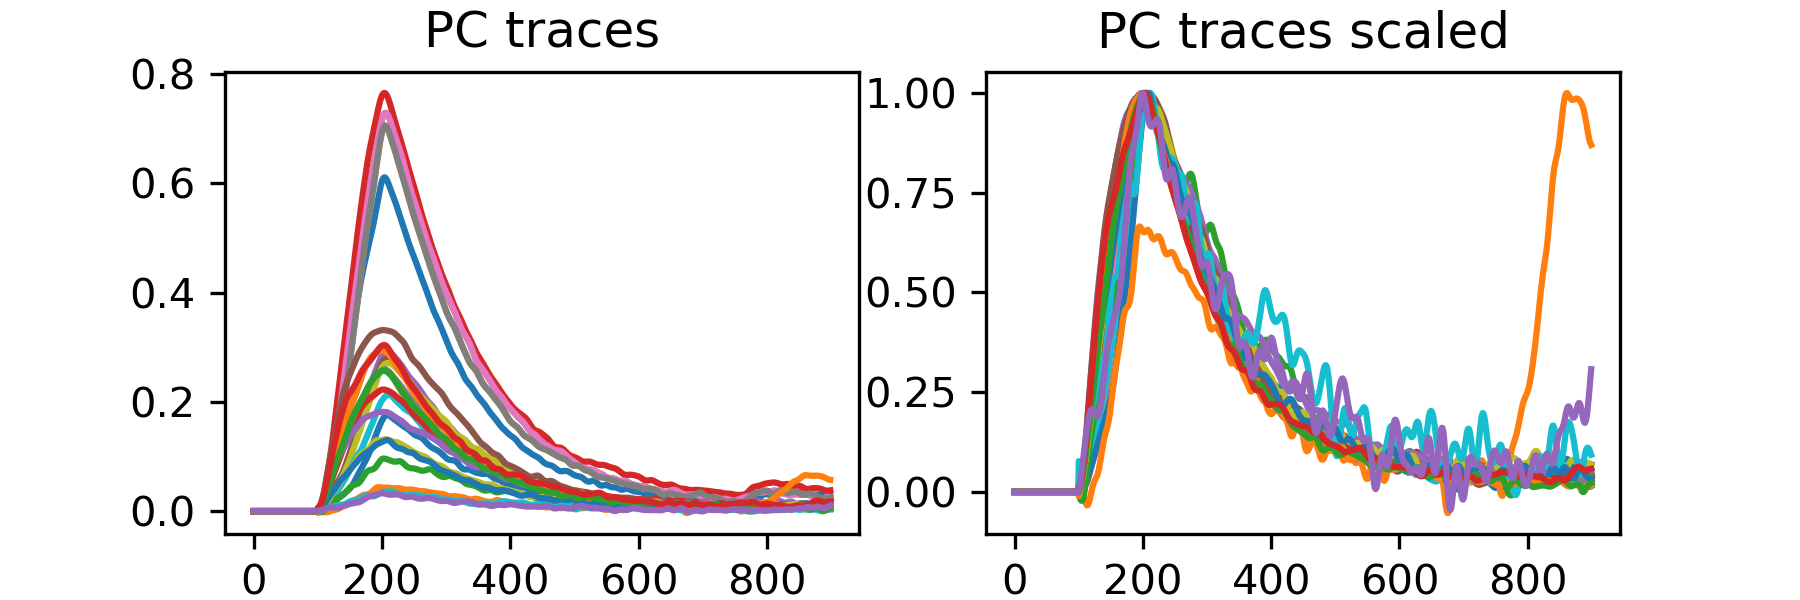

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,2), dpi=300)

pc_traces_scaled = pc_traces / np.max(pc_traces, axis=-1, keepdims=True)
axs[0].plot(pc_traces.T,)
axs[1].plot(pc_traces_scaled.T,)

axs[0].set_title('PC traces')
axs[1].set_title('PC traces scaled')
plt.show()


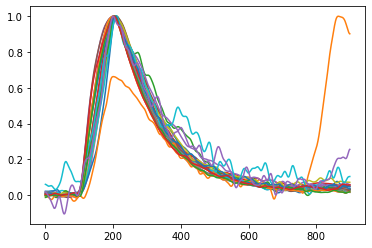

In [6]:
pc_traces_smoothed = np.copy(pc_traces)
pc_traces_smoothed = gaussian_filter1d(pc_traces, sigma=5)
pc_traces_smoothed /= np.max(pc_traces_smoothed, axis=-1, keepdims=True)
plt.plot(pc_traces_smoothed.T)
plt.show()

In [22]:
from turtle import pd


def replace_tail_with_bspline(trace, start_idx=300, end_idx=640, msecs_per_sample=0.05):
    def exp_func(x, a, b, c):
        return a * np.exp(b * x) + c

    x = np.arange(start_idx, end_idx) * 0.05
    y = trace[start_idx:end_idx]
    
    a0, b0, c0 = 0.1, -1/20, 0.5
    popt, pcov = curve_fit(
        exp_func,
        x, y,
        p0=(a0, b0, c0)
    )
    
    x2 = np.arange(end_idx, trace.shape[0]) * 0.05
    out = np.copy(trace)
    out[end_idx:] = exp_func(x2, *popt)
    return out

def _exp_func(t, a, b, c):
    ''' Exponential function
    '''
    return a * np.exp(b * t) + c


from scipy.optimize import curve_fit
def _fit_exponential_tail(trace, t, a0, b0, c0):
    '''
    Fit exponentials to the provided traces.
    params:
        traces: N x T array
    returns:
        a, b, c: length N arrays of parameters, such that the exponential
                 a[i] * exp(b[i] * t) + c[i] ~= traces[i] for i = 1,...,N
    '''
    popt, pcov = curve_fit(
        _exp_func,
        t, trace,
        p0=(a0, b0, c0)
    )
    return popt

def _extend_traces(
    traces,
    msecs_per_sample,
    num_samples_to_add,
    fit_start_idx=400,
    replace_start_idx=600,
    a0=0.1,
    b0=-1.0/20.0,
    c0=0.5
    ):
    N, window_len = traces.shape
    t_fit = np.arange(fit_start_idx, window_len) * msecs_per_sample
    params = [_fit_exponential_tail(trace, t_fit, a0, b0, c0)
        for trace in pc_traces[:, fit_start_idx:]]
    
    # create decaying exponentials of length num_samples_to_add
    t_new = np.arange(replace_start_idx, window_len + num_samples_to_add) \
         * msecs_per_sample
    extensions = np.array([_exp_func(t_new, *popt) for popt in params])

    # concatenate traces with estimated tails
    out = np.zeros((N, window_len + 2 * num_samples_to_add))
    out[:, num_samples_to_add:num_samples_to_add + replace_start_idx] = traces[:, 0:replace_start_idx]
    out[:, num_samples_to_add + replace_start_idx:] = extensions

    # extend beginning of trace by appending constant
    out[:, 0:num_samples_to_add] = traces[:,0:1]

    return out




In [44]:
from curses import window


def sample_from_templates(
    templates,
    size=100,
    jitter_ms=0.5,
    window_len=900,
    smoothing_sigma=5,
    max_scaling_frac=0.5,
    msecs_per_sample=0.05,
    stim_start=100,
    exponential_fit_start_idx=450,
    ):

    templates[:, 0:stim_start] = 0.0

    # extend templates so that we can sample using jitter
    num_samples_to_add =  int(np.round(jitter_ms / msecs_per_sample))
    extended_traces = _extend_traces(
        pc_traces,
        msecs_per_sample,
        num_samples_to_add,
        exponential_fit_start_idx,
    )
    extended_traces_smoothed = gaussian_filter1d(
        extended_traces, sigma=smoothing_sigma)
    
    out = np.zeros((size, templates.shape[-1]))
    for i in range(size):
        this_template_idx = np.random.randint(templates.shape[0])
        this_template = np.copy(extended_traces_smoothed[this_template_idx])
        this_scale = 1.0 + np.random.uniform(low=-max_scaling_frac, high=max_scaling_frac)
        this_template *= this_scale

        # sample jitter in number of samples to shift
        this_jitter_samples = np.random.randint(low=-num_samples_to_add, high=num_samples_to_add)
        start_idx = num_samples_to_add + this_jitter_samples
        out[i] = this_template[start_idx:start_idx + window_len]
    return out



pc_traces[:, 0:100] = 0.0
extended_traces = _extend_traces(
    pc_traces,
    msecs_per_sample,
    100,
    450,
)
extended_traces_smoothed = gaussian_filter1d(extended_traces, sigma=5)


/Users/Bantin/anaconda3/envs/circuitmap/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


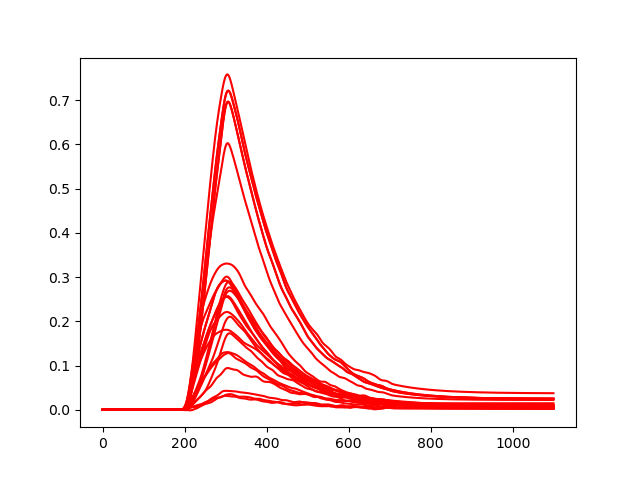

In [45]:
%matplotlib widget

plt.figure()
t_full = np.arange(0, 900) * msecs_per_sample
for trace, extended_trace in zip(pc_traces, extended_traces_smoothed):
    plt.plot(extended_trace, color='red')
    # plt.plot(trace, color='grey')
plt.show()

## augment real traces by scale and jitter

/Users/Bantin/anaconda3/envs/circuitmap/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


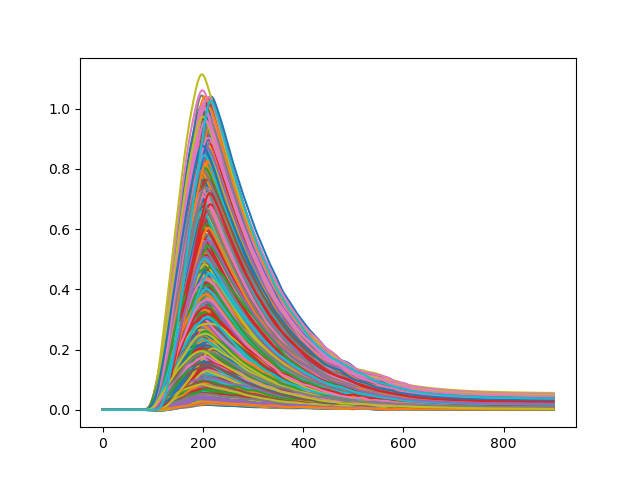

In [47]:
plt.figure()
sampled_real_traces = sample_from_templates(
    pc_traces,
    size=1000,
    jitter_ms=0.5,
)

plt.plot(sampled_real_traces.T)
plt.show()